# Train Model

## Load base model

In [1]:
from fastai.vision.all import *

In [2]:
def label_func(x):
    return str(x['file']).replace("images", "masks/obs0_rep0").replace("image","mask")

In [3]:
def acc_seg(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

def multi_dice(input:Tensor, targs:Tensor, class_id=0, inverse=False):
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    # replace all with class_id with 1 all else with 0 to have binary case
    output = (input == class_id).float()
    # same for targs
    targs = (targs.view(n,-1) == class_id).float()
    if inverse:
        output = 1 - output
        targs = 1 - targs
    intersect = (output * targs).sum(dim=1).float()
    union = (output+targs).sum(dim=1).float()
    res = 2. * intersect / union
    res[torch.isnan(res)] = 1
    return res.mean()

def diceComb(input:Tensor, targs:Tensor):
    return multi_dice(input, targs, class_id=0, inverse=True)
def diceLV(input:Tensor, targs:Tensor):
    return multi_dice(input, targs, class_id=1)
def diceMY(input:Tensor, targs:Tensor):
    return multi_dice(input, targs, class_id=2)

In [4]:
trainedModel = load_learner("../inputs/models/kaggle-ukbb-base-fastai2.pkl", cpu=False)

## Prepare data loading

In [5]:
all_files = sorted(glob.glob("../inputs/cmr-cine-sscrofa/data/png/images/*.png"))

In [6]:
df = pd.DataFrame({"file":all_files})
df

,file
0,../inputs/cmr-cine-sscrofa/data/png/images/A05_slice000_frame000-image.png
1,../inputs/cmr-cine-sscrofa/data/png/images/A05_slice000_frame001-image.png
2,../inputs/cmr-cine-sscrofa/data/png/images/A05_slice000_frame002-image.png
3,../inputs/cmr-cine-sscrofa/data/png/images/A05_slice000_frame003-image.png
4,../inputs/cmr-cine-sscrofa/data/png/images/A05_slice000_frame004-image.png
...,...
15895,../inputs/cmr-cine-sscrofa/data/png/images/A47_slice013_frame025-image.png
15896,../inputs/cmr-cine-sscrofa/data/png/images/A47_slice013_frame026-image.png
15897,../inputs/cmr-cine-sscrofa/data/png/images/A47_slice013_frame027-image.png
15898,../inputs/cmr-cine-sscrofa/data/png/images/A47_slice013_frame028-image.png


In [7]:
df = df.assign(
    id=lambda x: [z.split("/")[-1].split("_")[0] for z in x['file']],
    frame=lambda x: [int(z.split("/")[-1].split("_")[2][5:8]) for z in x['file']],
)
df

,file,id,frame
0,../inputs/cmr-cine-sscrofa/data/png/images/A05_slice000_frame000-image.png,A05,0
1,../inputs/cmr-cine-sscrofa/data/png/images/A05_slice000_frame001-image.png,A05,1
2,../inputs/cmr-cine-sscrofa/data/png/images/A05_slice000_frame002-image.png,A05,2
3,../inputs/cmr-cine-sscrofa/data/png/images/A05_slice000_frame003-image.png,A05,3
4,../inputs/cmr-cine-sscrofa/data/png/images/A05_slice000_frame004-image.png,A05,4
...,...,...,...
15895,../inputs/cmr-cine-sscrofa/data/png/images/A47_slice013_frame025-image.png,A47,25
15896,../inputs/cmr-cine-sscrofa/data/png/images/A47_slice013_frame026-image.png,A47,26
15897,../inputs/cmr-cine-sscrofa/data/png/images/A47_slice013_frame027-image.png,A47,27
15898,../inputs/cmr-cine-sscrofa/data/png/images/A47_slice013_frame028-image.png,A47,28


In [8]:
sets = pd.read_csv("../inputs/training/cmr-cine-sscrofa.sets.tsv", sep="\t")

In [9]:
df = pd.merge(df, sets)

In [10]:
esed = pd.read_csv("../inputs/cmr-cine-sscrofa/data/metadata/obs0_rep0.tsv", sep="\t")
esed = esed.melt(id_vars=['id'], value_vars=['es', 'ed'], var_name="phase", value_name="frame")
esed

,id,phase,frame
0,A05,es,10
1,A06,es,9
2,A07,es,9
3,A09,es,8
4,A10,es,9
...,...,...,...
75,A43,ed,29
76,A44,ed,29
77,A45,ed,29
78,A46,ed,29


In [11]:
df = pd.merge(df, esed)

In [12]:
df = df.assign(is_valid=lambda x: x['set']=="val")

In [13]:
df.set.value_counts()

train    560
test     288
val      212
Name: set, dtype: int64

In [14]:
train_val = df[df.set != "test"]

In [15]:
train_val.set.value_counts()

train    560
val      212
Name: set, dtype: int64

In [16]:
train_val.is_valid.value_counts()

False    560
True     212
Name: is_valid, dtype: int64

In [17]:
heart = DataBlock(blocks=(ImageBlock, MaskBlock(codes = np.array(["background","left_ventricle","myocardium"]))),
        get_x=ColReader("file"),
        get_y = label_func,
        splitter = ColSplitter(col="is_valid"),
        item_tfms=Resize(512, method='crop'),
        batch_tfms=aug_transforms(do_flip=True,max_rotate=90,max_lighting=.4,max_zoom=1.2,size=256))

In [18]:
import ctypes

magma_path = '/tank/home/ankenbrand/miniconda3/lib/libmagma.so'
magma_path = '/tank/home/ankenbrand/miniconda3/pkgs/magma-2.5.4-h6103c52_2/lib/libmagma.so'
libmagma = ctypes.cdll.LoadLibrary(magma_path)
libmagma.magma_init()

0

In [26]:
dls = heart.dataloaders(train_val, bs=16)

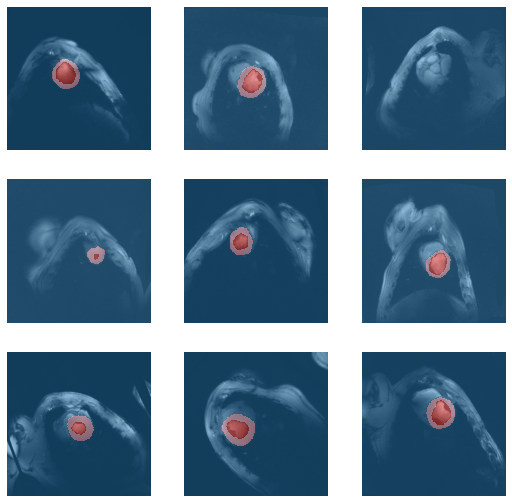

In [27]:
dls.show_batch()

## Make predictions with base model

In [28]:
img = Image.open("../inputs/cmr-cine-sscrofa/data/png/images/A05_slice004_frame029-image.png").resize((256,256))

In [29]:
pred, bla, blub = trainedModel.predict("../inputs/cmr-cine-sscrofa/data/png/images/A05_slice004_frame029-image.png")

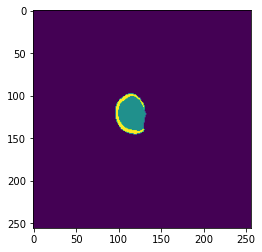

In [30]:
plt.imshow(pred)

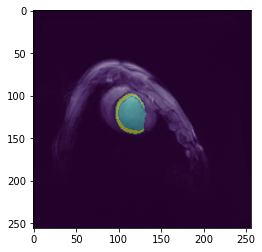

In [31]:
plt.imshow(img, cmap="bone")
plt.imshow(pred, alpha=.5)

In [32]:
trainedModel.dls = dls

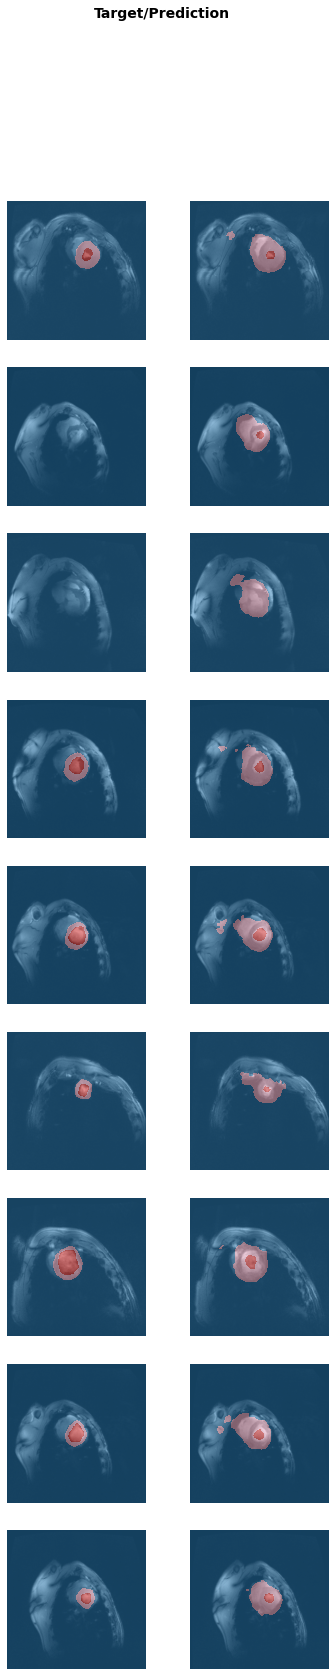

In [33]:
trainedModel.show_results()

## Retrain model

In [59]:
trainedModel.path = Path("../model")

In [42]:
trainedModel.add_cbs([CSVLogger(append=True)])

In [43]:
trainedModel.freeze()

SuggestedLRs(valley=3.630780702224001e-05)

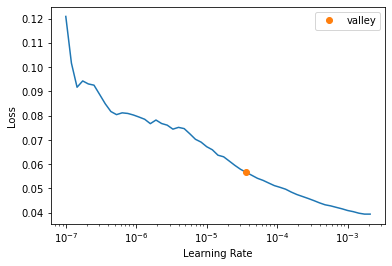

In [44]:
trainedModel.lr_find()

In [45]:
for i in range(10):
    trainedModel.fit_one_cycle(10, lr_max=1e-4)
    trainedModel.save("{}-epochs".format(10*i+10))

epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,0.030028,0.013220,0.995126,0.767796,0.789488,0.689761,00:14
1,0.019869,0.010809,0.995705,0.793402,0.813536,0.714211,00:14
2,0.016031,0.009544,0.996148,0.809511,0.832483,0.734320,00:15
3,0.013243,0.009726,0.996003,0.850765,0.820400,0.771472,00:14
4,0.011923,0.009152,0.996316,0.828693,0.841935,0.755105,00:15
5,0.011159,0.009806,0.995961,0.830260,0.836564,0.755891,00:15
6,0.010607,0.008572,0.996421,0.847838,0.848185,0.773631,00:14
7,0.009852,0.008877,0.996310,0.857769,0.843150,0.783108,00:14
8,0.009241,0.008829,0.996340,0.856102,0.842256,0.781962,00:15
9,0.008929,0.008777,0.996368,0.854116,0.843243,0.780018,00:15


epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,0.008670,0.009201,0.996325,0.854035,0.845189,0.780317,00:15
1,0.008788,0.011080,0.995929,0.862332,0.828345,0.780874,00:15
2,0.010265,0.009206,0.996336,0.822704,0.843347,0.746009,00:15
3,0.010072,0.008501,0.996383,0.847105,0.840411,0.770727,00:15
4,0.009559,0.008661,0.996331,0.864577,0.849827,0.788766,00:15
5,0.009111,0.008631,0.996506,0.874141,0.856513,0.800760,00:15
6,0.008587,0.008758,0.996570,0.873108,0.857885,0.799373,00:15
7,0.008223,0.009053,0.996533,0.880036,0.841732,0.805327,00:15
8,0.007889,0.009121,0.996492,0.878419,0.849561,0.805682,00:15
9,0.007941,0.009233,0.996495,0.875173,0.847749,0.802588,00:15


epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,0.007248,0.009559,0.996418,0.878346,0.843144,0.806737,00:15
1,0.007768,0.009882,0.996070,0.867653,0.844898,0.794126,00:15
2,0.008010,0.010008,0.996116,0.860475,0.854080,0.783145,00:15
3,0.008593,0.009101,0.996216,0.843201,0.824756,0.769399,00:15
4,0.008260,0.008938,0.996483,0.843403,0.844337,0.764149,00:15
5,0.008189,0.008998,0.996271,0.841453,0.846575,0.766338,00:15
6,0.007515,0.008829,0.996645,0.883185,0.848340,0.811240,00:15
7,0.007561,0.008307,0.996678,0.873474,0.851779,0.802608,00:15
8,0.007319,0.008672,0.996597,0.872483,0.851002,0.801444,00:15
9,0.007087,0.008633,0.996618,0.872397,0.849407,0.801662,00:15


epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,0.007059,0.008919,0.996540,0.864578,0.845671,0.792708,00:15
1,0.007228,0.009153,0.996460,0.862923,0.835653,0.785230,00:15
2,0.007594,0.010290,0.996412,0.850641,0.851057,0.778233,00:15
3,0.008303,0.010648,0.995728,0.835534,0.819991,0.770319,00:15
4,0.007871,0.008870,0.996556,0.873254,0.848216,0.802601,00:15
5,0.007411,0.009000,0.996553,0.846482,0.845003,0.772203,00:15
6,0.007292,0.008843,0.996601,0.862881,0.853048,0.788534,00:15
7,0.006997,0.008845,0.996546,0.850509,0.851121,0.778081,00:15
8,0.006930,0.008793,0.996584,0.858728,0.850743,0.785790,00:15
9,0.006683,0.008748,0.996583,0.855821,0.852590,0.783360,00:15


epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,0.006480,0.008767,0.996598,0.856382,0.855417,0.785405,00:15
1,0.006774,0.009435,0.996578,0.866939,0.858406,0.797067,00:15
2,0.007196,0.008776,0.996613,0.870330,0.846447,0.799167,00:15
3,0.007319,0.008306,0.996677,0.862192,0.859778,0.790448,00:15
4,0.007425,0.009299,0.996587,0.841128,0.847565,0.771808,00:15
5,0.006976,0.009517,0.996421,0.863369,0.844310,0.790130,00:15
6,0.006874,0.008913,0.996577,0.819605,0.849624,0.754054,00:15
7,0.006891,0.008419,0.996739,0.863768,0.861328,0.794522,00:15
8,0.006576,0.008460,0.996697,0.863091,0.857141,0.791768,00:15
9,0.006513,0.008416,0.996713,0.862841,0.857837,0.792703,00:15


epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,0.006353,0.008826,0.996712,0.850764,0.845288,0.781838,00:15
1,0.006813,0.009010,0.996322,0.831180,0.843023,0.761239,00:15
2,0.007085,0.009212,0.996533,0.866491,0.837466,0.789132,00:15
3,0.006953,0.009288,0.996669,0.863783,0.847953,0.792301,00:15
4,0.007081,0.009002,0.996451,0.862889,0.851596,0.790239,00:15
5,0.007008,0.009050,0.996496,0.870209,0.846854,0.797057,00:15
6,0.006765,0.009318,0.996589,0.858431,0.850484,0.787939,00:15
7,0.006558,0.009830,0.996497,0.866474,0.850951,0.794185,00:15
8,0.006304,0.009879,0.996605,0.866243,0.856051,0.793852,00:15
9,0.006268,0.009990,0.996579,0.858802,0.854675,0.787594,00:15


epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,0.006275,0.009810,0.996571,0.855547,0.857136,0.784553,00:15
1,0.006648,0.008409,0.996488,0.824345,0.832138,0.759168,00:15
2,0.006901,0.010535,0.996362,0.871589,0.850786,0.796313,00:15
3,0.006855,0.008861,0.996513,0.850367,0.852498,0.782051,00:15
4,0.006886,0.008925,0.996381,0.821271,0.839712,0.758969,00:15
5,0.006565,0.010187,0.996387,0.837637,0.842161,0.769527,00:15
6,0.006329,0.010193,0.996446,0.835005,0.844945,0.768882,00:15
7,0.006196,0.010057,0.996514,0.836125,0.843401,0.771021,00:15
8,0.006016,0.010176,0.996574,0.862437,0.841831,0.792426,00:15
9,0.005955,0.010140,0.996589,0.868501,0.846018,0.797854,00:15


epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,0.005854,0.010205,0.996600,0.869461,0.845139,0.799032,00:15
1,0.006153,0.010044,0.996596,0.856882,0.848860,0.787104,00:15
2,0.006205,0.011585,0.996230,0.858531,0.816973,0.782897,00:15
3,0.006842,0.011262,0.996441,0.858861,0.852172,0.785167,00:15
4,0.007027,0.009227,0.996402,0.833651,0.843674,0.764521,00:15
5,0.006661,0.009483,0.996424,0.851600,0.844558,0.780654,00:15
6,0.006410,0.010422,0.996569,0.873601,0.849691,0.801376,00:15
7,0.006201,0.010366,0.996531,0.866633,0.854622,0.795865,00:15
8,0.006098,0.010272,0.996520,0.860037,0.849593,0.788500,00:15
9,0.006180,0.010363,0.996535,0.862688,0.846332,0.792083,00:15


epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,0.005891,0.010689,0.996524,0.862680,0.848027,0.791062,00:15
1,0.005884,0.011368,0.996367,0.843010,0.837496,0.770457,00:15
2,0.006348,0.011856,0.996318,0.823336,0.837509,0.759178,00:15
3,0.006467,0.011737,0.996566,0.884139,0.844729,0.805927,00:15
4,0.006669,0.010508,0.996512,0.860414,0.852710,0.790662,00:15
5,0.006690,0.010891,0.996161,0.853308,0.842839,0.781989,00:15
6,0.006530,0.010883,0.996298,0.821502,0.834146,0.754343,00:15
7,0.006105,0.011158,0.996495,0.865742,0.856149,0.795185,00:15
8,0.005845,0.011395,0.996414,0.844550,0.834348,0.776932,00:15
9,0.005968,0.011213,0.996428,0.842501,0.832147,0.775820,00:15


epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,0.005741,0.010847,0.996481,0.857373,0.847461,0.788336,00:15
1,0.005869,0.011415,0.996474,0.820925,0.831199,0.754945,00:15
2,0.006614,0.010441,0.996492,0.864604,0.845704,0.791589,00:15
3,0.006183,0.011841,0.996576,0.849813,0.842903,0.784830,00:15
4,0.006283,0.009419,0.996563,0.866366,0.855532,0.795578,00:15
5,0.006052,0.010606,0.996488,0.819147,0.832152,0.753823,00:15
6,0.005891,0.011767,0.996687,0.866944,0.862949,0.797356,00:15
7,0.005848,0.009909,0.996730,0.856417,0.859639,0.789035,00:15
8,0.005701,0.010081,0.996666,0.859963,0.855757,0.791599,00:15
9,0.005672,0.010198,0.996681,0.858639,0.859623,0.790680,00:15


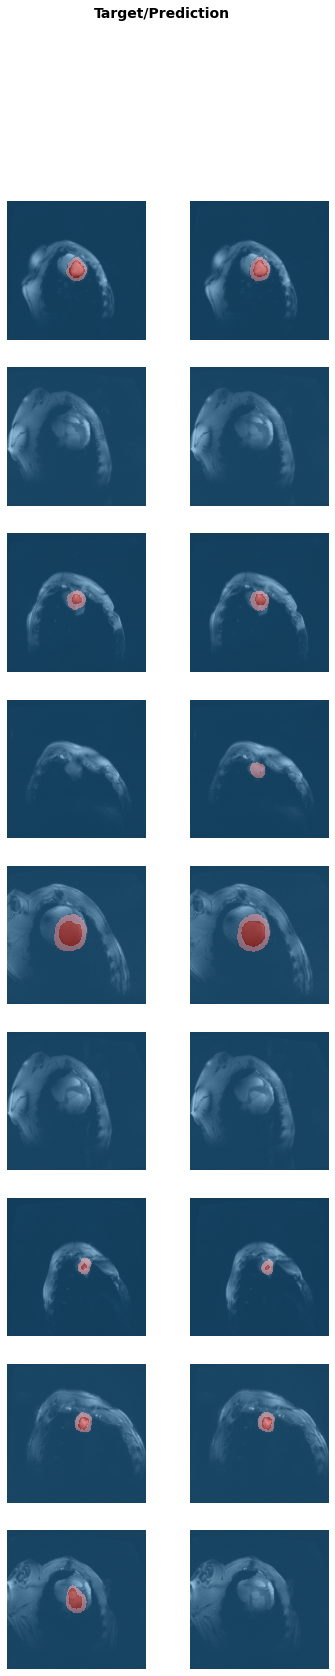

In [46]:
trainedModel.show_results()

In [47]:
trainedModel.unfreeze()

SuggestedLRs(valley=2.511886486900039e-05)

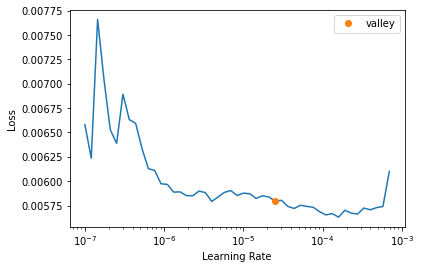

In [48]:
trainedModel.lr_find()

In [49]:
for i in range(10):
    trainedModel.fit_one_cycle(10, lr_max=1e-5)
    trainedModel.save("{}-epochs-unfrozen".format(10*i+10))

epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,0.005458,0.010335,0.996707,0.858756,0.858060,0.791086,00:14
1,0.005536,0.010346,0.996744,0.860913,0.854755,0.793496,00:14
2,0.005488,0.010627,0.996651,0.850182,0.850699,0.781814,00:14
3,0.005514,0.010770,0.996578,0.860462,0.849601,0.792883,00:14
4,0.005588,0.010398,0.996545,0.856016,0.853537,0.787292,00:14
5,0.005576,0.010890,0.996548,0.865248,0.853700,0.796270,00:14
6,0.005582,0.010859,0.996627,0.855906,0.853320,0.789492,00:14
7,0.005576,0.011015,0.996531,0.859776,0.847085,0.791763,00:14
8,0.005543,0.011041,0.996530,0.859232,0.850088,0.791566,00:14
9,0.005476,0.010992,0.996555,0.858757,0.851182,0.790981,00:14


epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,0.005700,0.011059,0.996619,0.858606,0.854641,0.791389,00:14
1,0.005499,0.011278,0.996610,0.856060,0.851198,0.789073,00:14
2,0.005774,0.011247,0.996622,0.858108,0.845614,0.790457,00:15
3,0.005877,0.010164,0.996562,0.843150,0.841500,0.776023,00:14
4,0.005673,0.010707,0.996680,0.859172,0.850722,0.792074,00:14
5,0.005724,0.010547,0.996660,0.854365,0.853814,0.788040,00:14
6,0.005601,0.010658,0.996670,0.859465,0.855680,0.792661,00:14
7,0.005533,0.010858,0.996662,0.861839,0.854016,0.794976,00:14
8,0.005480,0.010830,0.996687,0.862602,0.854214,0.795404,00:14
9,0.005531,0.010920,0.996674,0.864839,0.858045,0.797331,00:14


epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,0.005413,0.011033,0.996663,0.861523,0.854311,0.794527,00:15
1,0.005440,0.011431,0.996640,0.858583,0.857032,0.791903,00:14
2,0.005340,0.011060,0.996691,0.859125,0.852337,0.791542,00:15
3,0.005499,0.009734,0.996579,0.849646,0.850170,0.782821,00:14
4,0.005537,0.011292,0.996627,0.857013,0.851277,0.788771,00:15
5,0.005691,0.009476,0.996518,0.851151,0.845095,0.783389,00:14
6,0.005586,0.009611,0.996566,0.855928,0.840905,0.788314,00:14
7,0.005452,0.009758,0.996593,0.855704,0.844777,0.788280,00:15
8,0.005408,0.009726,0.996579,0.855048,0.849238,0.788110,00:14
9,0.005400,0.009611,0.996626,0.855471,0.848216,0.788478,00:14


epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,0.005336,0.009907,0.996608,0.854632,0.848083,0.787714,00:14
1,0.005439,0.010143,0.996638,0.860332,0.857849,0.792981,00:14
2,0.005420,0.010349,0.996549,0.851417,0.845471,0.783533,00:14
3,0.005665,0.010425,0.996617,0.845888,0.837967,0.779139,00:14
4,0.005622,0.010199,0.996667,0.860562,0.850300,0.793794,00:14
5,0.005476,0.009833,0.996626,0.856301,0.845268,0.789554,00:14
6,0.005377,0.010268,0.996636,0.850913,0.846274,0.783850,00:14
7,0.005393,0.010536,0.996633,0.852620,0.847639,0.785224,00:14
8,0.005411,0.010482,0.996640,0.857509,0.846645,0.789947,00:15
9,0.005380,0.010399,0.996648,0.852404,0.847013,0.784905,00:14


epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,0.005354,0.010591,0.996648,0.856610,0.851416,0.789323,00:15
1,0.005296,0.010734,0.996649,0.846633,0.849607,0.780970,00:15
2,0.005335,0.011192,0.996627,0.844031,0.849125,0.776995,00:14
3,0.005353,0.010634,0.996506,0.851137,0.841480,0.784038,00:14
4,0.005368,0.011458,0.996466,0.827677,0.845176,0.762638,00:14
5,0.005279,0.011510,0.996473,0.839171,0.848462,0.773453,00:14
6,0.005285,0.011491,0.996486,0.839879,0.842283,0.773791,00:14
7,0.005301,0.011486,0.996468,0.839352,0.844419,0.773314,00:15
8,0.005497,0.011332,0.996500,0.842879,0.848356,0.777005,00:15
9,0.005413,0.011467,0.996490,0.840869,0.844331,0.774923,00:15


epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,0.005323,0.011579,0.996543,0.839761,0.848523,0.774249,00:14
1,0.005363,0.011325,0.996468,0.834888,0.843825,0.768369,00:15
2,0.005279,0.011929,0.996493,0.841697,0.841132,0.774426,00:15
3,0.005261,0.011235,0.996445,0.827383,0.840088,0.761640,00:14
4,0.005295,0.011847,0.996414,0.830975,0.837507,0.764997,00:15
5,0.005294,0.011944,0.996425,0.825707,0.838784,0.759274,00:15
6,0.005247,0.012369,0.996465,0.833140,0.843106,0.768093,00:14
7,0.005280,0.012159,0.996436,0.836922,0.840159,0.771633,00:15
8,0.005262,0.012072,0.996475,0.840473,0.840903,0.774823,00:14
9,0.005235,0.012185,0.996468,0.841157,0.841381,0.775068,00:15


epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,0.005187,0.012003,0.996460,0.841064,0.836287,0.774785,00:15
1,0.005315,0.011634,0.996472,0.841714,0.837356,0.775333,00:14
2,0.005440,0.012215,0.996559,0.847833,0.837726,0.780995,00:14
3,0.005433,0.011815,0.996441,0.834748,0.828783,0.768327,00:14
4,0.005375,0.012220,0.996555,0.843813,0.838136,0.777652,00:14
5,0.005324,0.012391,0.996474,0.842106,0.830130,0.775280,00:15
6,0.005295,0.012819,0.996475,0.828924,0.835429,0.764901,00:14
7,0.005244,0.012703,0.996518,0.835121,0.840370,0.771026,00:14
8,0.005233,0.012715,0.996520,0.835927,0.840411,0.771349,00:14
9,0.005240,0.012872,0.996505,0.834303,0.839862,0.770183,00:14


epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,0.005200,0.012779,0.996567,0.837182,0.840866,0.772673,00:14
1,0.005250,0.012468,0.996482,0.834409,0.827677,0.768503,00:14
2,0.005250,0.013097,0.996538,0.833435,0.835900,0.769803,00:14
3,0.005288,0.012784,0.996567,0.833415,0.841598,0.769193,00:14
4,0.005188,0.012461,0.996547,0.848906,0.849663,0.782859,00:15
5,0.005218,0.012614,0.996539,0.841634,0.841223,0.775601,00:15
6,0.005282,0.012325,0.996509,0.843318,0.841700,0.776853,00:14
7,0.005267,0.012387,0.996555,0.840819,0.841525,0.774795,00:14
8,0.005273,0.012408,0.996577,0.842117,0.841560,0.775637,00:15
9,0.005230,0.012429,0.996604,0.840267,0.845743,0.774119,00:14


epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,0.005163,0.012553,0.996627,0.847040,0.845176,0.781408,00:15
1,0.005289,0.012606,0.996691,0.851057,0.856102,0.785054,00:14
2,0.005262,0.012813,0.996647,0.836927,0.857040,0.772757,00:14
3,0.005235,0.012602,0.996636,0.846356,0.840249,0.779875,00:14
4,0.005230,0.012079,0.996621,0.848266,0.845946,0.781895,00:15
5,0.005213,0.012701,0.996696,0.853566,0.849729,0.788143,00:15
6,0.005215,0.012800,0.996674,0.848710,0.847515,0.782311,00:15
7,0.005270,0.012589,0.996622,0.842631,0.842827,0.777024,00:14
8,0.005214,0.012547,0.996659,0.844022,0.847600,0.778614,00:14
9,0.005200,0.012545,0.996662,0.844220,0.852248,0.778824,00:15


epoch,train_loss,valid_loss,acc_seg,diceComb,diceLV,diceMY,time
0,0.005244,0.012606,0.996658,0.844541,0.852294,0.779208,00:14
1,0.005271,0.013858,0.996580,0.856220,0.852478,0.791172,00:15
2,0.005338,0.011936,0.996435,0.832146,0.833814,0.766743,00:14
3,0.005288,0.012249,0.996474,0.840477,0.841212,0.774741,00:15
4,0.005290,0.012648,0.996526,0.847441,0.840183,0.782597,00:14
5,0.005202,0.012590,0.996513,0.844711,0.841041,0.778164,00:14
6,0.005226,0.012272,0.996518,0.844855,0.841946,0.779501,00:14
7,0.005239,0.012485,0.996539,0.844303,0.846294,0.778490,00:15
8,0.005202,0.012764,0.996600,0.849269,0.845316,0.783302,00:15
9,0.005182,0.012646,0.996603,0.847959,0.840998,0.782319,00:15


In [50]:
a,b,c = trainedModel.get_preds(with_input = True)

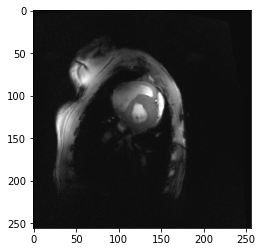

In [51]:
plt.imshow(a[9].permute(1,2,0))

In [52]:
a[9].permute(1,2,0).max()

TensorImage(1.)

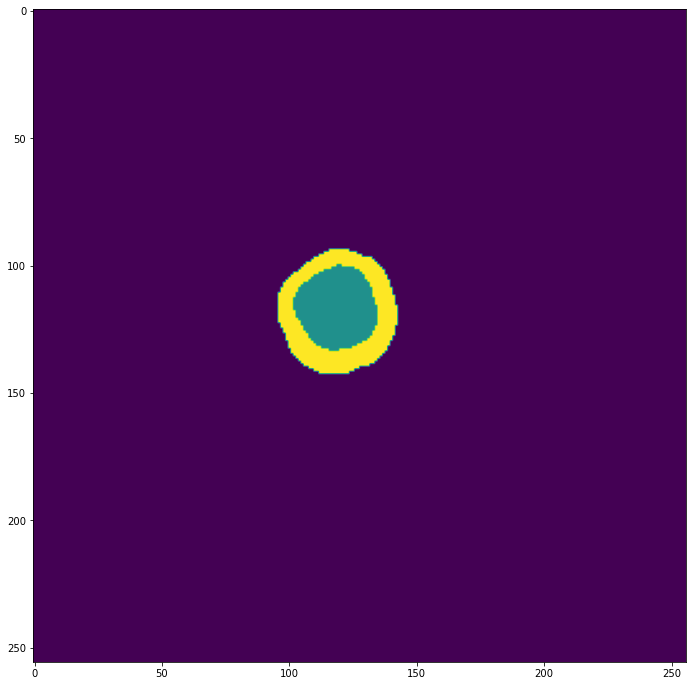

In [54]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(trainedModel.predict("../inputs/cmr-cine-sscrofa/data/png/images/A05_slice005_frame010-image.png")[0])

In [55]:
trainedModel.remove_cb(CSVLogger)
trainedModel.export("100-epochs-unfrozen.pkl")